# Zambia Anwendung

Die Anwendungen basieren auf dem Datensatz `"~/Git/deepdl/data/zambia_test.csv"`.
Berechnungen werden in Python und in R ausgeführt.

## Forschungsfrage(n):
- Können wir Splines (GAMs) und Neuronale Netze verbinden?
- Können wir diese Verbindung über Gewichtsoptimierung nutzen?
- Reicht eine reparametrisierung aus oder müssen wir unser altes Kriterium anwenden?

_____

## Ablauf
1. (Einfaches) Model bauen
   1. Baseline in R
   2. Kombination in Python
      1. Nutzen von Reparametrisierung über Softmax Aktivierungsfunktion
         1. Theoretisch
         2. Numerisch
      2. Nutzen von asymptotic weighing Kriterium aus letztem Paper
   3. Vergleich
2. Komplexere Neuronale Netze nutzen
   1. Baseline in R
   2. Kombination in Python
      1. Nutzen von Reparametrisierung über Softmax Aktivierungsfunktion
      2. Nutzen von asymptotic weighing Kriterium aus letztem Paper
   3. Vergleich
3. Fazit

____

# 1. (Einfaches) Model bauen

Im Rahmen der ersten Anwendung nutze ich hier den Zambia Datensatz. 
Ziel ist es hierbei zum einen eine Spline über eine Ausprägung zu fitten, während über eine andere ein neuronales Netz mit einem Input gefittet werden sollte.
Hierbei wird für das Neuronale Netz eine größte genommen, welche explizit non-lineares Verhalten aufweist. 
Wir versuchen diese über ein Neuronales Netz mit Hidden Layern zu modellieren.

Um eine Vergleichbarkeit und Einschätzung der Performance der Modelle zu ermöglichen fitten wir erst einmal drei Baseline Modelle in R.
Das jeweils zwei Modelle mit der Modellierung nur einer Ausprägung und das letzte Modell sich die kombinierten Fähigkeiten anschaut.

Die ausgewählten Größen sind hierbei extra die gleichen wie in unserem Zambia Beispiele in Deep DL.

🔥 ! WICHTIG ! 🔥
Die Splines im kombinierten Fall sind natürlich nicht gleich den Splines in den Solo-Fällen.

____

## 1.1. Baseline in R

Alle drei Modelle wurden in R mit MGCV gebaut. Gegeben sind die Modell-Summaries, sowie die jeweiligen effective oder korrigierten Degrees of Freedom.
Die effektiv Degrees of Freedom stammen aus mgcv Package selbst, während der korrigierte DF von der AIC.gam() Methode bestimmt wird.

edf  : Geschätzte Degrees of Freedom basierend auf den geschätzten Werten für jeden Modell-Parameter. Penalisierte Werte, daher nahe bzw. wengier als 1. <br>
edf1 : Alternativer Schätzer für EDF. <br> 
cdf  : Korrigierter Schätzer für die DF, basierend auf der Methode `AIC.gam()`.

### <u> 1.1.1. Model 1 </u> (c_age)

```R
Family: gaussian 
Link function: identity 

Formula:
zscore_norm ~ s(c_age) - 1

Approximate significance of smooth terms:
           edf Ref.df     F p-value    
s(c_age) 2.819  3.512 24.24  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0988   Deviance explained = 10.1%
GCV = 0.87046  Scale est. = 0.8674    n = 800

edf:    2.819355
edf1:   3.512079
cdf:    3.819355 
```
----

### <u> 1.1.2. Model 2 </u> (c_breastfd)

```R
Family: gaussian 
Link function: identity 

Formula:
zscore_norm ~ s(zambia$c_breastf) - 1

Approximate significance of smooth terms:
                      edf Ref.df     F p-value    
s(zambia$c_breastf) 8.055  8.727 9.816  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0932   Deviance explained = 10.1%
GCV = 0.88169  Scale est. = 0.87281   n = 800

---
edf:    8.054608
edf1:   8.727034
cdf:    9.054608

```

----

### <u> 1.1.3. Model 3 </u> (c_age + c_breastf)

```R
Family: gaussian 
Link function: identity 

Formula:
zscore_norm ~ s(c_age) + s(c_breastf) - 1

Approximate significance of smooth terms:
               edf Ref.df     F p-value    
s(c_age)     2.976  3.726 14.19  <2e-16 ***
s(c_breastf) 2.174  2.706  2.54  0.0515 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.108   Deviance explained = 11.3%
GCV = 0.86384  Scale est. = 0.85828   n = 800

---

edf:    5.150168
edf1:   6.43166
cdf:    6.150168
```

----

## 1.2. Kombination der Modelle

In [69]:
import random
import numpy as np
import pandas as pd         
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# # Einlesen der Fitted Values (MacOS)
# zambia = pd.read_csv("~/Git/deepdl/data/zambia_test.csv")
# y = zambia["zscore_norm"]
# c_age = zambia["c_age"]
# c_breastf = zambia["c_breastf"]
# m1_fitted = pd.read_csv("/Users/rkruse/Git/dfDeepDL/anwendung/m1_fitted.csv")
# m1_plot =  pd.read_csv("/Users/rkruse/Git/dfDeepDL/anwendung/m1_plot_data.csv")
# nn1_pred = pd.read_csv("/Users/rkruse/Git/dfDeepDL/anwendung/nn1_pred.csv")
# m2_fitted = pd.read_csv("/Users/rkruse/Git/dfDeepDL/anwendung/m2_fitted.csv")
# m2_plot =  pd.read_csv("/Users/rkruse/Git/dfDeepDL/anwendung/m2_plot_data.csv")
# nn2_pred = pd.read_csv("/Users/rkruse/Git/dfDeepDL/anwendung/nn2_pred.csv")


In [79]:
zambia = pd.read_csv('C:/Users/rene-/Git/dfDeepDL/anwendung/zambia_test.csv')
y = zambia["zscore_norm"]
c_age = zambia["c_age"]
c_breastf = zambia["c_breastf"]

m1_fitted = pd.read_csv("C:/Users/rene-/Git/dfDeepDL/anwendung/m1_fitted.csv")
m1_plot =  pd.read_csv("C:/Users/rene-/Git/dfDeepDL/anwendung/m1_plot_data.csv")
nn1_pred = pd.read_csv("C:/Users/rene-/Git/dfDeepDL/anwendung//nn1_pred.csv")

m2_fitted = pd.read_csv("C:/Users/rene-/Git/dfDeepDL/anwendung/m2_fitted.csv")
m2_plot =  pd.read_csv("C:/Users/rene-/Git/dfDeepDL/anwendung/m2_plot_data.csv")
nn2_pred = pd.read_csv("C:/Users/rene-/Git/dfDeepDL/anwendung/nn2_pred.csv")

### Fitten der Neuronalen Netze

In [71]:
random.seed(42)
tf.random.set_seed(42)
m1 = tf.keras.Sequential()
m1.add(tf.keras.layers.Dense(10, activation='relu', batch_input_shape=(None, 1)))
m1.add(tf.keras.layers.Dense(10, activation='relu'))
m1.add(tf.keras.layers.Dense(1, activation='linear'))
m1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001))
hist1 = m1.fit(c_breastf, y, epochs = 2500, batch_size=400, use_multiprocessing=True, verbose=0)

Text(0.5, 0, 'epoch')

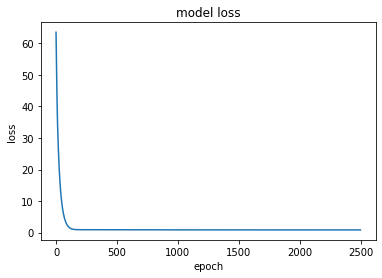

In [72]:
plt.plot(hist1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [73]:
random.seed(42)
tf.random.set_seed(42)
m2 = tf.keras.Sequential()
m2.add(tf.keras.layers.Dense(10, activation='relu', batch_input_shape=(None, 1)))
m2.add(tf.keras.layers.Dense(10, activation='relu'))
m2.add(tf.keras.layers.Dense(1, activation='linear'))
m2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001))
hist2 = m2.fit(c_age, y, epochs = 2500, batch_size=400, use_multiprocessing=True, verbose=0)

Text(0.5, 0, 'epoch')

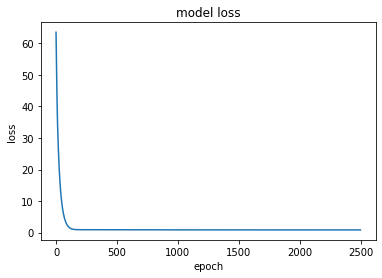

In [74]:
plt.plot(hist1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

### Predictions berechnen:

In [75]:
nn1_pred = m1.predict(c_breastf)
nn2_pred = m2.predict(c_age)

### Zielgrößen ausrechnen

$$
    C(w) = || y - \hat{y}(w) ||^{2} + 2 \hat{\sigma}^{2} w^{T} \rho
$$

- y : Response
- $\hat{y}(w)$ : $\sum w_i \hat{y}_i$ 
  - $\hat{y}_{nn1}$ : prediction c_breastf (nn1_pred), 
  - $\hat{y}_{nn2}$ : prediction c_age (nn2_pred),
  - $\hat{y}_{s1}$  : c_age Spline fit (m1_fitted),
  - $\hat{y}_{s2}$  : c_breastf Spline fit (m2_fitted),
- $\sigma^{2}$ : Varianz des Modells mit den größten Degrees of Freedom (vgl. Hansen(2007), Greven & Kneib(2010)),
- $\rho$ : Vektor der Degree of Freedoms der Kandidaten Modelle.
  - $\rho_n1$ : 
  - $\rho_n2$ :
  - $\rho_s1$ :
  - $\rho_s2$ :   

In [ ]:
# Varianz
## für die ersten Kombination:
sig1 = 2.819355
## für die zweite Kombinatio:
sig2 = 8.054608

In [76]:
y = np.array(y)
m1_fitted = np.array(m1_fitted)
m2_fitted = np.array(m2_fitted)

In [77]:
y = y.reshape(800, 1)
m1_fitted = m1_fitted.reshape(800, 1)
m2_fitted = m2_fitted.reshape(800, 1)
nn1_pred = nn1_pred.reshape(800, 1)
nn2_pred = nn2_pred.reshape(800, 1)

In [78]:
np.savetxt('C:/Users/rene-/Git/dfDeepDL/anwendung/nn1_pred.csv', nn1_pred, delimiter=",")
np.savetxt('C:/Users/rene-/Git/dfDeepDL/anwendung/nn2_pred.csv', nn2_pred, delimiter=",")

## 1.2. Augmented Lagrangian Lösungen zum Vergleich:

Spline : c_age <br>
NN: c_breastf

Input 1: 0.48356 <br>
Input 2: 0.51644
___

### 1.2.1 Reparametrisierung

Zuerst "händische" Berechnung. 
`tf.nn.softmax(
    logits, axis=None, name=None
)`

In [ ]:
# Input 1 (Spline c_age):
in1 = np.matmul(np.transpose(y - np.array(m1_fitted)), (y - np.array(m1_fitted))) + 2 * sig1 * 2.819355

In [ ]:
# Input 2 (NN für c_breasstf):
in2 = np.matmul(np.transpose(y - np.array(nn1_pred)), (y - np.array(nn1_pred))) + 2 * sig1 * 2.819355

In [ ]:
# Nervige umformungen weil TF nicht mit arrays umgehen kann ... yeah.
print(in1[0][0])
print(in2[0][0])

In [ ]:
in1 = np.matmul(np.transpose(y - np.array(m2_fitted)), (y - np.array(m2_fitted))) + 2 * sig1 * 2.819355

In [ ]:
in2 = np.matmul(np.transpose(y - np.array(nn2_pred)), (y - np.array(nn2_pred))) + 2 * sig1 * 2.819355

In [ ]:
# Nervige umformungen weil TF nicht mit arrays umgehen kann ... yeah.
print(in1[0][0])
print(in2[0][0])

### Alternative: Über NN zusammenführen

In [ ]:
preds = np.array((m1_fitted, nn1_pred)).reshape(800, 2)

In [ ]:
random.seed(42)
tf.random.set_seed(42)
m3 = tf.keras.Sequential()
m3.add(tf.keras.layers.Dense(1, use_bias=False,  activation='linear', batch_input_shape=(None, 2)))
m3.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001))
hist3 = m3.fit(preds, y, epochs = 2500, batch_size=400, use_multiprocessing=True, verbose=0)

In [ ]:
plt.plot(hist3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

```R
> in3 = c(-0.0628522)
> in4 = c(-0.3302423)
> exp(in3) / (exp(in3) + exp(in4))
[1] 0.5664521
> exp(in4) / (exp(in3) + exp(in4))
[1] 0.4335479

```

```R
Iter: 1 fn: 698.3652	 Pars:  0.18087 0.81913
Iter: 2 fn: 698.3652	 Pars:  0.18087 0.81913
Completed in 2 major iterations

$pars
[1] 0.1808668 0.8191332

$convergence
[1] 0

$values
[1] 700.3247 698.3652 698.3652

$lagrange
          [,1]
[1,] 0.3650089

$hessian
          [,1]      [,2]
[1,]  5.892774 -8.516229
[2,] -8.516229 15.574318

$ineqx0
NULL

$nfuneval
[1] 53

$outer.iter
[1] 2

$elapsed
Time difference of 0.02200007 secs

$vscale
[1] 698.36517448   0.00000001   1.00000000   1.00000000


```

____

# Spline 1: c_age



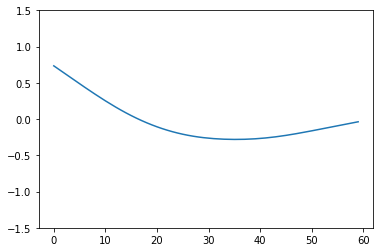

In [80]:
plt.plot(m1_plot["c_age"], m1_plot["m1_pred"])
plt.ylim(-1.5, 1.5)
plt.show()

____

# Spline 2: c_breastf

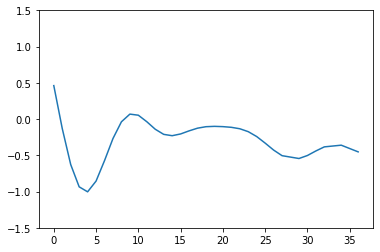

In [81]:
plt.plot(m2_plot["c_breastf"], m2_plot["m2_pred"])
plt.ylim(-1.5, 1.5)
plt.show()

____

# Neuronales Netz 1: c_breastf


In [82]:
plot_nn1 = pd.concat([c_breastf, nn1_pred], axis=1)
test = plot_nn1.sort_values(by="c_breastf")

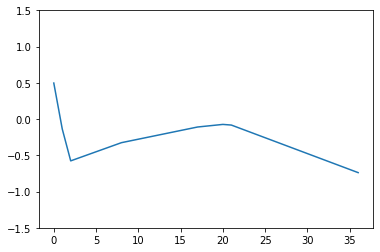

In [84]:
plt.plot(test["c_breastf"], test["nn1_pred"])
plt.ylim(-1.5, 1.5)
plt.show()

____

# Neuronales Netz: c_age

In [85]:
plot_nn2 = pd.concat([c_age, nn2_pred], axis=1)
df = plot_nn2.sort_values(by=['c_age'])

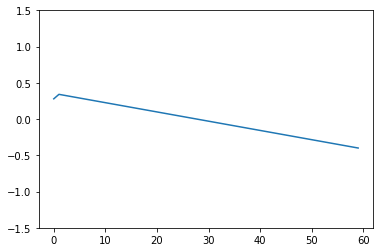

In [87]:
plt.plot(df["c_age"], df["nn2_pred"])
plt.ylim(-1.5, 1.5)
plt.show()

____ 

# Kombination beider spline(c_age) und ann(c_breastf)

In [90]:
# Optim Gewichte.
weights = np.array((0.1808668, 0.8191332))
# weights

array([0.1808668, 0.8191332])